<h5> 0. 라이브러리 가져오기 </h5>

In [1]:
import pandas as pd
import os
import json
import sys
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn


/home/changsu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3> 1. 데이터 로드 </h3>

In [2]:
# data load
os.path.dirname(os.path.abspath("__file__"))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from src.model.MCAoAN_vgg19 import MCAoAN
from src.utils.vocab_dict import VocabDict
import json

qst_vocab_path = "../datasets/vocab_questions.txt"
ans_vocab_path = "../datasets/vocab_answers.txt"

qst_vocab = VocabDict(qst_vocab_path)
ans_vocab = VocabDict(ans_vocab_path)

qst_vocab_size = qst_vocab.vocab_size
ans_vocab_size = ans_vocab.vocab_size

val_annotation_data = json.load(open(os.path.join('..', 'datasets', 'Annotations', 'v2_mscoco_val2014_annotations.json')))
val_annotation = pd.DataFrame(val_annotation_data["annotations"])
val_question_data = json.load(open(os.path.join('..', 'datasets', 'Questions', 'v2_OpenEnded_mscoco_val2014_questions.json')))
val_question = pd.DataFrame(val_question_data["questions"])

print(f"question num: {val_question.size}")

question num: 643062


<h5> 모델 로드</h5>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
rcnn_model.roi_heads.nms_thresh = 0.7
rcnn_model.eval().to(device)

print("faster rcnn load done!")

faster rcnn load done!


In [4]:
PATH = '../final_model/MCAoAN_vgg19_img20_emb64_glove-epoch-13.ckpt'
mcaoan_model = MCAoAN(
    ans_vocab_size= ans_vocab_size,
    qst_vocab_size= qst_vocab_size,
    dropout_rate= 0.5,
    embed_size=64,
).to(device)
mcaoan_model.load_state_dict(torch.load(os.path.join(PATH))["model_state_dict"])
mcaoan_model.eval()

print('mcaoan model load done!')

mcaoan model load done!


In [5]:
from src.model.VGG19_Tansformer import Transformer_VQA

PATH = '../final_model/VGG19+Transformer-epoch-19.ckpt'
SBERT_model = Transformer_VQA(
    ans_vocab_size=ans_vocab_size,
    dropout_rate=0.5,
).to(device)
SBERT_model.load_state_dict(torch.load(os.path.join(PATH))["state_dict"])
SBERT_model.eval()

print('SBERT model load done!')

SBERT model load done!


In [6]:
from src.model.VGG19_LSTM import LSTM_VQA

PATH = '../final_model/VGG19+LSTM-epoch-17.ckpt'
LSTM_model = LSTM_VQA(
    embed_size=1024,
    qst_vocab_size=qst_vocab_size,
    word_embed_size=300,
    num_layers=2,
    hidden_size=512,
    ans_vocab_size=ans_vocab_size,
    dropout_rate=0.5,
).to(device)
LSTM_model.load_state_dict(torch.load(os.path.join(PATH))["state_dict"])
LSTM_model.eval()

print('LSTM model load done!')

LSTM model load done!


<h5> See Attention </h5>


104000
.. datasets Images val2014 COCO_val2014_000000451305.jpg
question attention: are(0.00) these(0.00) male(0.00) or(0.17) female(0.29) zebras(0.24) ?(0.31)
Question: Are these male or female zebras?
GroundTruth: ['male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male']
MCAoAN: male
LSTM: male
SBERT: female
['0.50', '0.50']


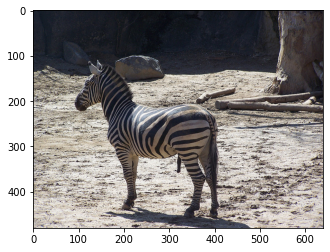

104001
.. datasets Images val2014 COCO_val2014_000000451305.jpg
question attention: what(0.00) is(0.00) the(0.00) zebra(0.02) doing(0.47) ?(0.50)
Question: What is the zebra doing?
GroundTruth: ['standing', 'standing', 'standing', 'standing', 'standing', 'standing', 'standing', 'standing', 'standing', 'standing']
MCAoAN: standing
LSTM: eating
SBERT: standing
['0.54', '0.46']


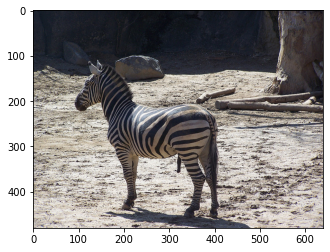

104002
.. datasets Images val2014 COCO_val2014_000000451305.jpg
question attention: is(0.00) this(0.00) indoors(0.00) our(0.18) outdoors(0.44) ?(0.37)
Question: Is this indoors our outdoors?
GroundTruth: ['outdoors', 'outdoors', 'outdoors', 'outdoors', 'outdoors', 'outdoors', 'outdoors', 'outdoors', 'outdoors', 'outdoors']
MCAoAN: outdoors
LSTM: outdoors
SBERT: indoors
['0.52', '0.48']


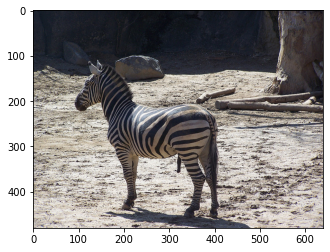

104003
.. datasets Images val2014 COCO_val2014_000000451305.jpg
question attention: how(0.00) many(0.01) stripes(0.24) are(0.25) there(0.26) ?(0.25)
Question: How many stripes are there?
GroundTruth: ['30', '65', '8', 'over 50', '100', 'many', 'many', '30', '23', '50']
MCAoAN: many
LSTM: many
SBERT: 100
['0.51', '0.49']


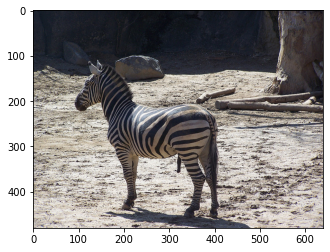

104004
.. datasets Images val2014 COCO_val2014_000000451305.jpg
104005
.. datasets Images val2014 COCO_val2014_000000451305.jpg
question attention: what(0.01) color(0.01) are(0.01) the(0.00) zebra(0.15) in(0.14) the(0.07) middle(0.19) '(0.05) s(0.07) legs(0.12) ?(0.18)
Question: What color are the zebra in the middle's legs?
GroundTruth: ['black and white', 'black and white', 'white, black', 'black and white', 'black and white', 'black and white', 'black', 'black and white', 'black and white', 'black and white']
MCAoAN: black and white
LSTM: brown
SBERT: white and black
['0.51', '0.49']


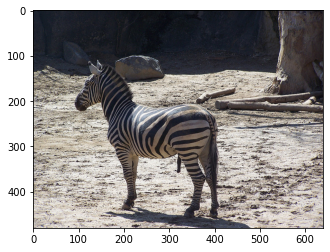

104006
.. datasets Images val2014 COCO_val2014_000000451305.jpg
104007
.. datasets Images val2014 COCO_val2014_000000189163.jpg
question attention: what(0.01) is(0.01) on(0.01) the(0.01) person(0.00) '(0.00) s(0.00) wrist(0.45) ?(0.52)
Question: What is on the person's wrist?
GroundTruth: ['watch', 'watch', 'watch', 'watch', 'watch', 'watch', 'watch', 'bracelet', 'watch', 'watch']
MCAoAN: watch
LSTM: watch
SBERT: bracelet
['0.13', '0.09', '0.07', '0.07', '0.07', '0.06', '0.06', '0.05', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.02', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.00', '0.00']


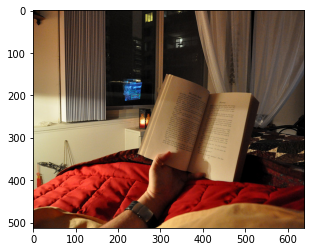

104008
.. datasets Images val2014 COCO_val2014_000000189163.jpg
104009
.. datasets Images val2014 COCO_val2014_000000189163.jpg
104010
.. datasets Images val2014 COCO_val2014_000000189163.jpg
question attention: what(0.02) is(0.02) the(0.01) red(0.08) object(0.35) ?(0.52)
Question: What is the red object?
GroundTruth: ['blanket', 'comforter', 'comforter', 'blanket', 'cover', 'cover', 'comforter', 'blanket', 'blanket', 'blanket']
MCAoAN: tie
LSTM: laptop
SBERT: pillow
['0.15', '0.13', '0.09', '0.08', '0.08', '0.07', '0.06', '0.06', '0.06', '0.04', '0.03', '0.02', '0.02', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.00']


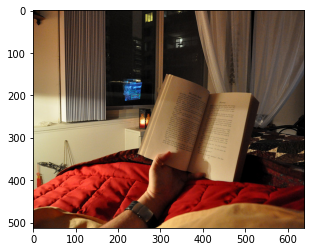

104011
.. datasets Images val2014 COCO_val2014_000000451308.jpg
question attention: what(0.01) items(0.03) does(0.01) this(0.01) person(0.01) collect(0.47) ?(0.46)
Question: What items does this person collect?
GroundTruth: ['suitcases', 'suitcases', 'suitcases', 'suitcases', 'suitcases', 'suitcases', 'suitcases', 'suitcases', 'suitcases', 'suitcases']
MCAoAN: <unk>
LSTM: <unk>
SBERT: books
['0.08', '0.07', '0.07', '0.07', '0.07', '0.06', '0.06', '0.05', '0.05', '0.05', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02', '0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


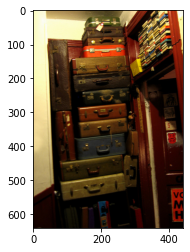

104012
.. datasets Images val2014 COCO_val2014_000000451308.jpg
question attention: how(0.01) many(0.01) suitcases(0.14) are(0.15) blue(0.33) ?(0.36)
Question: How many suitcases are blue?
GroundTruth: ['1', '2', '2', '1', '1', '1', '1', '1', '2', '1']
MCAoAN: 1
LSTM: 0
SBERT: 1
['0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02', '0.02', '0.02', '0.02', '0.02', '0.01', '0.01']


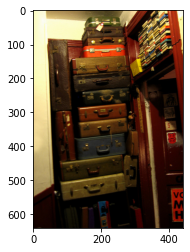

104013
.. datasets Images val2014 COCO_val2014_000000451308.jpg
question attention: how(0.00) many(0.00) different(0.02) colors(0.06) of(0.14) briefcases(0.37) ?(0.41)
Question: How many different colors of briefcases?
GroundTruth: ['5', '11', '8', '6', '12', '4', '9', '8', '9', '9']
MCAoAN: 2
LSTM: 2
SBERT: 4
['0.05', '0.05', '0.05', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01']


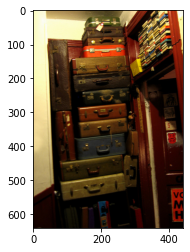

104014
.. datasets Images val2014 COCO_val2014_000000189168.jpg
question attention: what(0.01) color(0.02) is(0.01) the(0.01) batter(0.04) '(0.01) s(0.02) shirt(0.41) ?(0.47)
Question: What color is the batter's shirt?
GroundTruth: ['orange and black', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange and black', 'orange']
MCAoAN: red
LSTM: blue
SBERT: blue
['0.15', '0.14', '0.11', '0.10', '0.09', '0.08', '0.08', '0.06', '0.03', '0.02', '0.02', '0.02', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


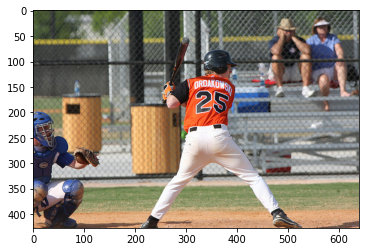

104015
.. datasets Images val2014 COCO_val2014_000000189168.jpg
question attention: what(0.01) is(0.01) the(0.01) batter(0.01) '(0.01) s(0.01) number(0.35) ?(0.60)
Question: What is the batter's number?
GroundTruth: ['25', '25', '25', '25', '25', '25', '25', '25', '25', '25']
MCAoAN: 9
LSTM: 13
SBERT: 28
['0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02']


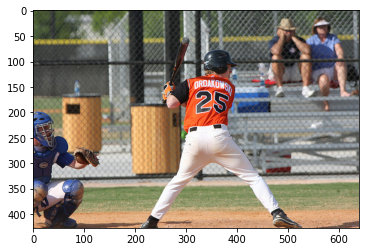

104016
.. datasets Images val2014 COCO_val2014_000000189168.jpg
question attention: what(0.00) is(0.00) the(0.00) name(0.01) of(0.00) the(0.00) player(0.12) up(0.21) to(0.19) bat(0.15) ?(0.30)
Question: What is the name of the player up to bat?
GroundTruth: ['drazkowski', 'ordakowski', 'ordakowski', 'ordakowski', 'oroakowski', 'ordakowski', 'oroakowso', '25', 'ordakowski', 'ordakowski']
MCAoAN: catcher
LSTM: bat
SBERT: batter
['0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03']


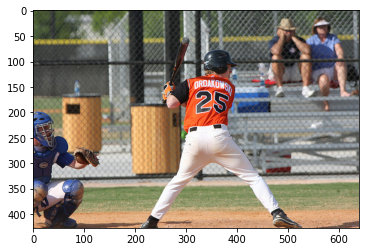

104017
.. datasets Images val2014 COCO_val2014_000000320246.jpg
104018
.. datasets Images val2014 COCO_val2014_000000320246.jpg
104019
.. datasets Images val2014 COCO_val2014_000000320246.jpg
104020
.. datasets Images val2014 COCO_val2014_000000320246.jpg
question attention: what(0.02) is(0.02) the(0.02) man(0.01) holding(0.45) ?(0.48)
Question: What is the man holding?
GroundTruth: ['bike', 'bike', 'bike', 'bike', 'bike', 'bike', 'bike', 'bicycle', 'bicycle', 'bicycle']
MCAoAN: suitcase
LSTM: umbrella
SBERT: newspaper
['0.53', '0.07', '0.05', '0.05', '0.05', '0.03', '0.03', '0.02', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


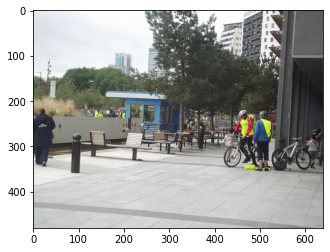

104021
.. datasets Images val2014 COCO_val2014_000000320246.jpg
question attention: how(0.03) many(0.03) people(0.05) are(0.07) on(0.14) bikes(0.32) ?(0.36)
Question: How many people are on bikes?
GroundTruth: ['1', '0', '1', '1', '1', '1', '1', '1', '1', '1']
MCAoAN: 2
LSTM: 1
SBERT: 1
['0.07', '0.07', '0.07', '0.06', '0.06', '0.06', '0.06', '0.05', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.01', '0.01', '0.01']


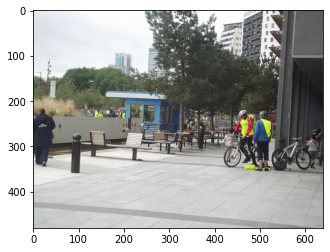

104022
.. datasets Images val2014 COCO_val2014_000000320246.jpg
question attention: can(0.15) you(0.11) see(0.20) cars(0.24) ?(0.30)
Question: Can you see cars?
GroundTruth: ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']
MCAoAN: yes
LSTM: no
SBERT: yes
['0.06', '0.06', '0.06', '0.06', '0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01']


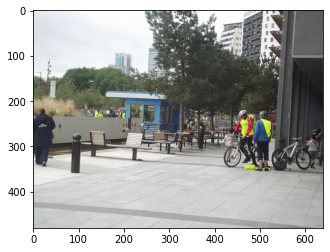

104023
.. datasets Images val2014 COCO_val2014_000000320246.jpg
question attention: what(0.01) is(0.01) the(0.01) boy(0.01) riding(0.42) ?(0.54)
Question: What is the boy riding?
GroundTruth: ['bike', 'bike', 'nothing', 'no boy', 'bicycle', 'bike', 'bike', 'bike', 'bike', 'nothing']
MCAoAN: bike
LSTM: bicycle
SBERT: bike
['0.24', '0.16', '0.16', '0.13', '0.09', '0.05', '0.03', '0.03', '0.03', '0.02', '0.01', '0.01', '0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


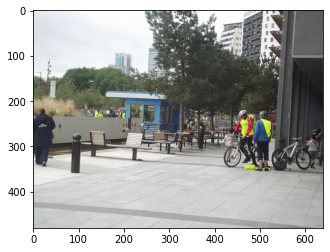

104024
.. datasets Images val2014 COCO_val2014_000000320246.jpg
104025
.. datasets Images val2014 COCO_val2014_000000320246.jpg
question attention: what(0.02) is(0.02) the(0.01) color(0.03) of(0.05) the(0.03) photo(0.50) ?(0.34)
Question: What is the color of the photo?
GroundTruth: ['blue, yellow, red, green, white, grey, black', 'blue, yellow, green and black', 'blue, yellow, red, gray, white', 'white', 'gray', 'many', 'blue, yellow, gray, white, green', 'gray', 'mostly gray', 'color']
MCAoAN: blue
LSTM: black and white
SBERT: black and white
['0.13', '0.12', '0.10', '0.08', '0.07', '0.07', '0.07', '0.06', '0.06', '0.04', '0.03', '0.03', '0.03', '0.03', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


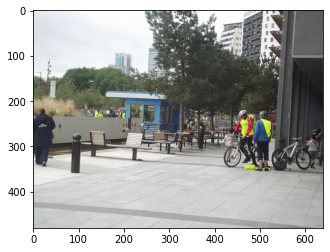

104026
.. datasets Images val2014 COCO_val2014_000000320246.jpg
question attention: how(0.00) many(0.00) skyscrapers(0.15) are(0.23) there(0.32) ?(0.30)
Question: How many skyscrapers are there?
GroundTruth: ['4', '4', '5', '1', '2', '4', '4', '6', '3', '4']
MCAoAN: 3
LSTM: 1
SBERT: 1
['0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03']


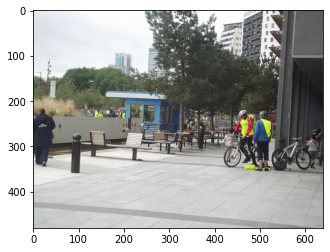

104027
.. datasets Images val2014 COCO_val2014_000000320249.jpg
question attention: how(0.03) many(0.03) bikes(0.18) are(0.24) there(0.24) ?(0.28)
Question: How many bikes are there?
GroundTruth: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
MCAoAN: 1
LSTM: 2
SBERT: 2
['0.08', '0.07', '0.07', '0.07', '0.07', '0.06', '0.05', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.01', '0.01', '0.01']


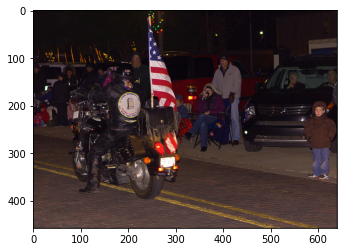

104028
.. datasets Images val2014 COCO_val2014_000000320249.jpg
104029
.. datasets Images val2014 COCO_val2014_000000320249.jpg
104030
.. datasets Images val2014 COCO_val2014_000000320249.jpg
question attention: what(0.01) is(0.01) the(0.00) flag(0.05) on(0.35) ?(0.58)
Question: What is the flag on?
GroundTruth: ['motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'motorcycle', 'bike', 'motorcycle']
MCAoAN: motorcycle
LSTM: <unk>
SBERT: american
['0.18', '0.17', '0.16', '0.12', '0.11', '0.03', '0.02', '0.02', '0.02', '0.02', '0.02', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.01', '0.00', '0.00', '0.00', '0.00', '0.00']


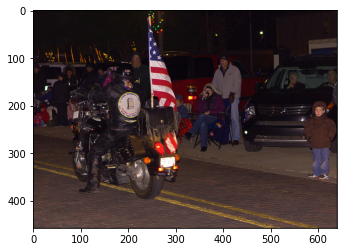

104031
.. datasets Images val2014 COCO_val2014_000000320249.jpg
question attention: what(0.00) country(0.16) '(0.15) s(0.11) flag(0.14) is(0.18) prominently(0.17) displayed(0.04) ?(0.06)
Question: What country's flag is prominently displayed?
GroundTruth: ['usa', 'usa', 'usa', 'usa', 'united states of america', 'usa', 'usa', 'usa', 'united states', 'american']
MCAoAN: usa
LSTM: usa
SBERT: united states
['0.10', '0.07', '0.07', '0.06', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02', '0.02']


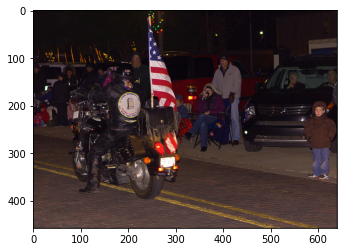

104032
.. datasets Images val2014 COCO_val2014_000000320249.jpg
104033
.. datasets Images val2014 COCO_val2014_000000320249.jpg
question attention: is(0.06) it(0.08) a(0.08) sunny(0.28) day(0.25) ?(0.25)
Question: Is it a sunny day?
GroundTruth: ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no']
MCAoAN: no
LSTM: yes
SBERT: no
['0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02']


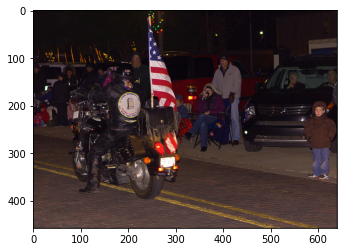

104034
.. datasets Images val2014 COCO_val2014_000000320249.jpg
104035
.. datasets Images val2014 COCO_val2014_000000320249.jpg
104036
.. datasets Images val2014 COCO_val2014_000000451324.jpg
104037
.. datasets Images val2014 COCO_val2014_000000451324.jpg
104038
.. datasets Images val2014 COCO_val2014_000000451324.jpg
question attention: how(0.01) many(0.01) cups(0.13) are(0.16) on(0.17) the(0.18) table(0.17) ?(0.18)
Question: How many cups are on the table?
GroundTruth: ['4', '4', '3', '4', '4', '4', '4', '4', '4', '4']
MCAoAN: 2
LSTM: 2
SBERT: 1
['0.05', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.02', '0.02', '0.02', '0.01']


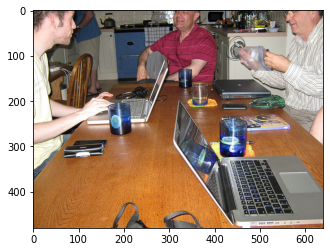

104039
.. datasets Images val2014 COCO_val2014_000000058111.jpg
104040
.. datasets Images val2014 COCO_val2014_000000058111.jpg
question attention: what(0.01) color(0.02) is(0.02) the(0.01) cat(0.45) ?(0.49)
Question: What color is the cat?
GroundTruth: ['orange', 'orange and white', 'orange,white', 'orange and white', 'tan,white', 'orange', 'brown and white', 'orange', 'orange', 'orange']
MCAoAN: orange
LSTM: orange
SBERT: orange and white
['0.26', '0.25', '0.25', '0.24', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']


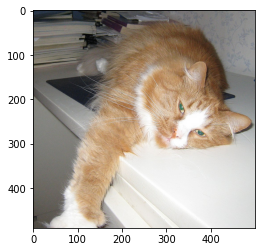

104041
.. datasets Images val2014 COCO_val2014_000000058111.jpg
104042
.. datasets Images val2014 COCO_val2014_000000058111.jpg
question attention: how(0.01) many(0.02) cats(0.18) can(0.23) you(0.19) see(0.18) ?(0.19)
Question: How many cats can you see?
GroundTruth: ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
MCAoAN: 1
LSTM: 1
SBERT: 2
['0.20', '0.13', '0.13', '0.12', '0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.04', '0.04']


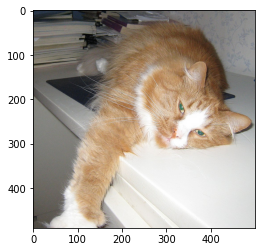

104043
.. datasets Images val2014 COCO_val2014_000000058111.jpg
question attention: what(0.00) color(0.00) is(0.00) the(0.00) cat(0.01) '(0.00) s(0.01) eyes(0.49) ?(0.49)
Question: What color is the cat's eyes?
GroundTruth: ['green', 'green', 'green', 'green', 'green', 'green', 'yellow', 'yellow', 'green', 'green']
MCAoAN: yellow
LSTM: brown
SBERT: orange and white
['0.14', '0.14', '0.13', '0.13', '0.08', '0.06', '0.06', '0.05', '0.05', '0.04', '0.04', '0.04', '0.04']


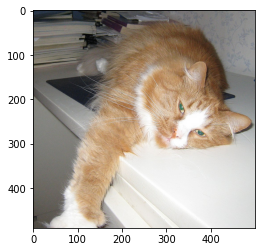

104044
.. datasets Images val2014 COCO_val2014_000000058117.jpg


FileNotFoundError: [Errno 2] No such file or directory: '../datasets/Image_Tensors/val2014/COCO_val2014_000000058117.npy'

In [18]:
from src.utils import text_helper
normalize: transforms.Normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
max_qst_length = 30
max_sub_img_num = 30

print()

def extract_data(data_idx: int):
    idx_answers = pd.DataFrame(val_annotation.loc[data_idx, 'answers'])
    quest = val_annotation.loc[data_idx, 'question_id']
    question = val_question[val_question['question_id']==quest]['question'][data_idx]
    image_id = val_question[val_question['question_id']==quest]['image_id'][data_idx]
    
    return question, idx_answers, image_id

transform_without_normalize = transforms.Compose([
    transforms.ToTensor(),
])
def load_image_data(image_id: int, max_sub_img_num: int):
    image_rgb = Image.open(os.path.join('..','datasets','Images','val2014', f'COCO_val2014_{image_id:012}.jpg')).convert("RGB")
    print('..','datasets','Images','val2014', f'COCO_val2014_{image_id:012}.jpg')
    
    image_feat = torch.from_numpy(
            np.load(
                os.path.join('..','datasets','Image_Tensors','val2014', f'COCO_val2014_{image_id:012}.npy')
            )
        )[:max_sub_img_num, :].unsqueeze(0).to(device)
    score_thr = 0.2
    image_mask = torch.from_numpy(
        np.load(
            os.path.join('..','datasets','Image_Scores','val2014', f'COCO_val2014_{image_id:012}.npy')
        )
    )[:max_sub_img_num].unsqueeze(0).to(device)
    image_mask = image_mask < score_thr

    return image_feat, image_mask, image_rgb

def tokenize_question(question):
    quest_idx_list = np.array(
        [qst_vocab.word2idx("<pad>")] * max_qst_length
    )
    question_tokens = text_helper.tokenize(question)
    quest_idx_list[: len(question_tokens)] = [
        qst_vocab.word2idx(w) for w in question_tokens
    ]
    question_tokens = torch.tensor(quest_idx_list, dtype=torch.int64, device=device).unsqueeze(0).to(device)
    return question_tokens, quest_idx_list

from transformers import AutoTokenizer

SBERT_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens', model_max_length=30)

idx_list = [
    10002,
    10015,
    10019,
    10025,
    10035,  
]
xxxx = 104000
OUTCNT = 0
for idx in range(xxxx, xxxx+1000, 1):
    question, answers, image_id = extract_data(idx)
    # if len(question) < 90:
    #     continue
    print(idx)
    image_feat, image_mask, image_rgb = load_image_data(image_id, max_sub_img_num)
    
    image_tensor = transform_without_normalize(image_rgb).unsqueeze(0).to(device)

    # get MCAoAN ans
    question_tokens, quest_idx_list = tokenize_question(question)
    res_rcnn = rcnn_model(image_tensor)
    res_MCAoAN = mcaoan_model.forward(image_feat, image_mask, question_tokens)
    
    # # get LSTM ans
    # one_image_feat = image_feat[:,0].unsqueeze(0).to(device)
    # res_LSTM = LSTM_model.forward(one_image_feat, image_mask, question_tokens)
    # LSTM_ans = ans_vocab.idx2word(torch.max(res_LSTM[0], 1)[1])
    
    # # get SBERT ans
    # SBERT_question_token = SBERT_tokenizer(question, padding='max_length', truncation=True, return_tensors='pt', max_length = 30)
    # res_SBERT = SBERT_model.forward(one_image_feat, image_mask, SBERT_question_token)
    # SBERT_ans = ans_vocab.idx2word(torch.max(res_SBERT[0][0], 1)[1])


    vqa_ans = res_MCAoAN[0]
    qst_att = res_MCAoAN[2]
    img_att = res_MCAoAN[3]
    _, pred_exp = torch.max(vqa_ans, 1)
    ans = ans_vocab.idx2word(pred_exp)
    if LSTM_ans == ans and LSTM_ans == SBERT_ans:
        continue
    print("question attention: " + ' '.join([f"{qst_vocab.idx2word(quest_idx)}({qst_att[0][idx].item():.2f})" for idx, quest_idx in enumerate(quest_idx_list) if quest_idx > 0]))
    print("Question: " + question)
    print(f"GroundTruth: {answers['answer'].tolist()}")
    print(f"MCAoAN: {ans}")
    print(f"LSTM: {LSTM_ans}")
    print(f"SBERT: {SBERT_ans}")

    # process_attention
    imgs = [
        {
            "box": torch.Tensor([0, 0, image_tensor.shape[3], image_tensor.shape[2]]),
            "att": img_att[0][0]
        } 
    ] + [
        {
            "box": res_rcnn[0]["boxes"][i],
            "att": img_att[0][i + 1]
        } for i in range(0, max_sub_img_num - 1) if image_mask[0][i + 1] == False
    ]
    imgs = sorted(imgs, key=lambda x : x["att"].item(), reverse=True)

    color_dict = ['red']*6 + ['yellow'] * 6 + ['green'] * 6 + ['blue'] * 6 + ['navy'] * 6
    print ([
        f'{img["att"].item():.2f}'
        for img in imgs
    ])
    fig,ax = plt.subplots(1)
    ax.imshow(image_rgb)
    plt.show()
    """
    fig,ax = plt.subplots(1)
    ax.imshow(image_rgb)
    print(f"idx: {idx}, frcnn 개수: {len(imgs)}")
    for idx, obj in enumerate(imgs):
        box = obj["box"]
        att = obj["att"]
        x1, y1, x2, y2 = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())
        box_plot = Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor=color_dict[idx], linewidth=1)
        plt.text(x1, y1, f"{idx}: {att.item():.2f}")
        ax.add_patch(box_plot)
    plt.show()
    for idx, obj in enumerate(imgs):
        box = obj["box"]
        att = obj["att"]
        if att < 1.1 / len(imgs):
            continue
        if idx > 5:
            break
        x1, y1, x2, y2 = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())
        fig, ax = plt.subplots(1)
        img_pil = Image.fromarray(np.array(image_rgb)[y1:y2,x1:x2,0:3])
        ax.imshow(img_pil)
        print(f"{att.item():.2f}")
        plt.show()
        """
    if OUTCNT > 100:
        break
    OUTCNT += 1